In [3]:
"""

hanze_qtl_workshop.ipynb

This script is for the Hanze QTL workshop
authors: Roy Oelen

"""


'\n\nhanze_qtl_workshop.ipynb\n\nThis script is for the Hanze QTL workshop\nauthors: Roy Oelen\n\n'

In [32]:
# we'll need these libraries
import pandas as pd
import seaborn as sbs
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from statsmodels.stats.multitest import multipletests


In [21]:
# we need to upload files if we are using colab
from google.colab import files
uploaded = files.upload()


Saving snp_locations_CeD_adjusted27082018_chr22.tsv.gz to snp_locations_CeD_adjusted27082018_chr22.tsv.gz


In [23]:
# the locations of our files
genotypes_loc = 'CeD_genotypes_adjusted27082018_chr22.txt'
expression_loc = 'geuvadis_normalised_gene_expression_adjusted27082018_chr22.txt'
variant_positions_loc = 'snp_locations_CeD_adjusted27082018_chr22.tsv.gz'
gene_positions_loc = 'gene_locations.txt'
# and let's load these
genotypes = pd.read_csv(genotypes_loc, sep = '\t', header = 0, index_col = 0)
expression = pd.read_csv(expression_loc, sep = '\t', header = 0, index_col = 0)
variant_positions = pd.read_csv(variant_positions_loc, sep = '\t', header = 0)
gene_positions = pd.read_csv(gene_positions_loc, sep = '\t', header = 0)


In [7]:
# we'll make sure the samples are present in both tables, and order them the same

# get which samples are in both
samples_both = genotypes.columns.intersection(expression.columns)
# and subset in that order for both tables
genotypes_aligned = genotypes[samples_both]
expression_aligned = expression[samples_both]


In [8]:
# we'll use a simple correlation to check if the first variant, and the first gene are correlated

# extract first gene first variant, the first row of each dataframe
first_variant = genotypes_aligned.iloc[0]
first_gene = expression_aligned.iloc[0]

# calculate the correlation and accompanying p value
first_correlation, first_p_value = spearmanr(first_variant, first_gene)

# print the result
print(''.join(['correlation of first gene to first variant:', str(first_correlation)]))
print(''.join(['p of first gene to first variant:', str(first_p_value)]))

# that is not going to look that great

correlation of first gene to first variant:0.051357776946506506
p of first gene to first variant:0.32256176781931767


In [9]:
# maybe we are just not testing enough, let's try to just do each variant against each gene

# we'll save the results in a list first
results = []

# check each variant
for variant in genotypes_aligned.index:
  # check each gene
  for feature in expression_aligned.index:
    # extract genotype and expression
    row_genotype = genotypes_aligned.loc[variant]
    row_expression = expression_aligned.loc[feature]
    # calculate stats
    correlation, p_value = spearmanr(row_genotype, row_expression)
    # put in a list
    results.append([variant, feature, correlation, p_value])

# put it all together
results_nowindow = pd.DataFrame(results, columns=['variant', 'feature', 'correlation', 'p_value'])


In [10]:
# let's see if we found anything this time
results_nowindow[results_nowindow['p_value'] < 0.05]


,variant,feature,correlation,p_value
13,rs2266959,ENSG00000099953,-0.110658,0.032634
32,rs2266959,ENSG00000100065,-0.127083,0.014045
47,rs2266959,ENSG00000100206,0.116140,0.024890
58,rs2266959,ENSG00000100298,0.162884,0.001597
89,rs2266959,ENSG00000128383,0.127327,0.013860
...,...,...,...,...
1489,rs2298428,ENSG00000225783,-0.111540,0.031265
1524,rs2298428,ENSG00000234630,-0.121226,0.019178
1556,rs2298428,ENSG00000251267,-0.120942,0.019464
1557,rs2298428,ENSG00000251322,-0.106247,0.040277


In [11]:
# wow, 69 effects. That is not entirely fair though, right? We should apply multiple testing correction

# get a bonferroni one
_, p_bonferroni, _, _ = multipletests(results_nowindow['p_value'], method='bonferroni')
results_nowindow['p_bonferroni'] = p_bonferroni

# and BH
_, p_bh, _, _ = multipletests(results_nowindow['p_value'], method='fdr_bh')
results_nowindow['p_bh'] = p_bh


In [12]:
# let's see how much is left with Bonferroni
results_nowindow[results_nowindow['p_bonferroni'] < 0.05]
# not great

,variant,feature,correlation,p_value,p_bonferroni,p_bh


In [13]:
# let's see how much is left with B&H instead
results_nowindow[results_nowindow['p_bh'] < 0.05]
# okay that is at least a bit more

,variant,feature,correlation,p_value,p_bonferroni,p_bh
103,rs2266959,ENSG00000161180,0.197769,0.000121,0.189447,0.047362
417,rs5754217,ENSG00000161180,0.208273,0.000050,0.079234,0.039617
731,rs7444,ENSG00000161180,0.208273,0.000050,0.079234,0.039617
1045,rs4821124,ENSG00000161180,0.197769,0.000121,0.189447,0.047362


In [16]:
# a previous study has show some eQTL effects. Let's see if we can replicate those then. First we need to load the data

# the location of this data
eqtlgen_confinement_loc = 'eqtlgen_fdr005_chr22.tsv.gz'
# read this data
eqtlgen_confinement = pd.read_csv(eqtlgen_confinement_loc, sep = '\t', header = 0)
# give it column names we like
# subset to just variant and feature
eqtlgen_confinement = eqtlgen_confinement[['SNP', 'Gene']]
# rename the columns to be the same as our output
eqtlgen_confinement = eqtlgen_confinement.rename({'SNP' : 'variant', 'Gene' : 'feature'}, axis = 1)
eqtlgen_confinement

,variant,feature
0,rs6007595,ENSG00000100376
1,rs104664,ENSG00000100376
2,rs738177,ENSG00000100376
3,rs7285172,ENSG00000100376
4,rs6006992,ENSG00000100376
...,...,...
270955,rs55649326,ENSG00000183506
270956,rs78192781,ENSG00000211685
270957,rs146878635,ENSG00000226328
270958,rs7287036,ENSG00000100243


In [18]:
# we already tested everything, so we can subset our results to what is in our confinement
results_eqtlgen = results_nowindow.merge(eqtlgen_confinement, on=['variant', 'feature'])
results_eqtlgen
# seems that based on B&H, we could replicate four of them


,variant,feature,correlation,p_value,p_bonferroni,p_bh
0,rs2266959,ENSG00000161180,0.197769,0.000121,0.189447,0.047362
1,rs5754217,ENSG00000161180,0.208273,0.000050,0.079234,0.039617
2,rs7444,ENSG00000161180,0.208273,0.000050,0.079234,0.039617
3,rs4821124,ENSG00000161180,0.197769,0.000121,0.189447,0.047362
4,rs2298428,ENSG00000161180,0.186297,0.000297,0.466764,0.093353


In [20]:
# if we would have only tried to replicate, we'd only have to correct for those
_, p_bonferroni_eqtlgen, _, _ = multipletests(results_eqtlgen['p_value'], method='bonferroni')
results_eqtlgen['p_bonferroni'] = p_bonferroni_eqtlgen
_, p_bh_eqtlgen, _, _ = multipletests(results_eqtlgen['p_value'], method='fdr_bh')
results_eqtlgen['p_bh'] = p_bh_eqtlgen
# let's see how many we would replicate then
results_eqtlgen
# which seems it is all of them


,variant,feature,correlation,p_value,p_bonferroni,p_bh
0,rs2266959,ENSG00000161180,0.197769,0.000121,0.000603,0.000151
1,rs5754217,ENSG00000161180,0.208273,0.000050,0.000252,0.000126
2,rs7444,ENSG00000161180,0.208273,0.000050,0.000252,0.000126
3,rs4821124,ENSG00000161180,0.197769,0.000121,0.000603,0.000151
4,rs2298428,ENSG00000161180,0.186297,0.000297,0.001487,0.000297


In [36]:
# it would be great if we have some extra information. let's see what we have for the snps
variant_positions

,variant,var_chr,var_pos
0,rs2266959,chr22,21922904
1,rs5754217,chr22,21939675
2,rs7444,chr22,21976934
3,rs4821124,chr22,21979289
4,rs2298428,chr22,21982892


In [25]:
# and what we have for the genes
gene_positions

,geneid,chr,left,right
0,ENSG00000223972,chr1,11869,14412
1,ENSG00000227232,chr1,14363,29806
2,ENSG00000243485,chr1,29554,31109
3,ENSG00000221311,chr1,30366,30503
4,ENSG00000237613,chr1,34554,36081
...,...,...,...,...
53929,ENSG00000198695,chrM,14149,14673
53930,ENSG00000210194,chrM,14674,14742
53931,ENSG00000198727,chrM,14747,15887
53932,ENSG00000210195,chrM,15888,15953


In [27]:
# let's rename the columns to make them both unique and matching where needed
variant_positions = variant_positions.rename({'snpid' : 'variant', 'chr' : 'var_chr', 'pos' : 'var_pos'}, axis = 1)
gene_positions = gene_positions.rename({'geneid' : 'feature', 'chr' : 'feature_chr', 'left' : 'feature_start', 'right' : 'feature_end'}, axis = 1)

# and add them to the output
results_nowindow = results_nowindow.merge(variant_positions, how = 'left', on = 'variant')
results_nowindow = results_nowindow.merge(gene_positions, how = 'left', on = 'feature')

# and let's see what they look like
results_nowindow


,variant,feature,correlation,p_value,p_bonferroni,p_bh,var_chr,var_pos,feature_chr,feature_start,feature_end
0,rs2266959,ENSG00000008735,0.051358,0.322562,1.0,0.914121,chr22,21922904,chr22,51039114,51052409
1,rs2266959,ENSG00000025708,0.041690,0.422084,1.0,0.952599,chr22,21922904,chr22,50964181,50968485
2,rs2266959,ENSG00000040608,0.047621,0.359067,1.0,0.914121,chr22,21922904,chr22,20228938,20270769
3,rs2266959,ENSG00000070371,-0.048108,0.354163,1.0,0.914121,chr22,21922904,chr22,19166986,19279239
4,rs2266959,ENSG00000073146,-0.049087,0.344448,1.0,0.914121,chr22,21922904,chr22,50528308,50600119
...,...,...,...,...,...,...,...,...,...,...,...
1565,rs2298428,ENSG00000254709,-0.051095,0.325044,1.0,0.914121,chr22,21982892,chr22,23229960,23238005
1566,rs2298428,ENSG00000256872,0.033948,0.513347,1.0,0.957284,chr22,21982892,chr22,38077680,38089483
1567,rs2298428,ENSG00000259421,-0.036411,0.483247,1.0,0.952599,chr22,21982892,chr22,39466419,39466676
1568,rs2298428,ENSG00000260065,0.021815,0.674518,1.0,0.985905,chr22,21982892,chr22,26917949,26921002


In [28]:
# we can also test less, by looking at variants close to genes. let's see how far the variants are from the flanks of the genes
results_nowindow['variant_to_start'] = results_nowindow['feature_start'] - results_nowindow['var_pos']
results_nowindow['variant_to_end'] = results_nowindow['feature_end'] - results_nowindow['var_pos']
results_nowindow

,variant,feature,correlation,p_value,p_bonferroni,p_bh,var_chr,var_pos,feature_chr,feature_start,feature_end,variant_to_start,variant_to_end
0,rs2266959,ENSG00000008735,0.051358,0.322562,1.0,0.914121,chr22,21922904,chr22,51039114,51052409,29116210,29129505
1,rs2266959,ENSG00000025708,0.041690,0.422084,1.0,0.952599,chr22,21922904,chr22,50964181,50968485,29041277,29045581
2,rs2266959,ENSG00000040608,0.047621,0.359067,1.0,0.914121,chr22,21922904,chr22,20228938,20270769,-1693966,-1652135
3,rs2266959,ENSG00000070371,-0.048108,0.354163,1.0,0.914121,chr22,21922904,chr22,19166986,19279239,-2755918,-2643665
4,rs2266959,ENSG00000073146,-0.049087,0.344448,1.0,0.914121,chr22,21922904,chr22,50528308,50600119,28605404,28677215
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1565,rs2298428,ENSG00000254709,-0.051095,0.325044,1.0,0.914121,chr22,21982892,chr22,23229960,23238005,1247068,1255113
1566,rs2298428,ENSG00000256872,0.033948,0.513347,1.0,0.957284,chr22,21982892,chr22,38077680,38089483,16094788,16106591
1567,rs2298428,ENSG00000259421,-0.036411,0.483247,1.0,0.952599,chr22,21982892,chr22,39466419,39466676,17483527,17483784
1568,rs2298428,ENSG00000260065,0.021815,0.674518,1.0,0.985905,chr22,21982892,chr22,26917949,26921002,4935057,4938110


In [31]:
# if we confine ourselves to variants at most 50k away from the gene, we should have lest tests
results_50kwindow = results_nowindow[((results_nowindow['variant_to_start'] > -50000) & (results_nowindow['variant_to_start'] < 50000)) | ((results_nowindow['variant_to_end'] > -50000) & (results_nowindow['variant_to_end'] < 50000))].copy()
# if we would have only tried in this window, we'd only have to correct for those
_, p_bonferroni_50k, _, _ = multipletests(results_50kwindow['p_value'], method='bonferroni')
results_50kwindow['p_bonferroni'] = p_bonferroni_50k
_, p_bh_50k, _, _ = multipletests(results_50kwindow['p_value'], method='fdr_bh')
results_50kwindow['p_bh'] = p_bh_50k

# so let's see what we have
results_50kwindow


,variant,feature,correlation,p_value,p_bonferroni,p_bh,var_chr,var_pos,feature_chr,feature_start,feature_end,variant_to_start,variant_to_end
416,rs5754217,ENSG00000161179,0.050886,0.327032,1.000000,0.498749,chr22,21939675,chr22,21982378,21984353,42703,44678
417,rs5754217,ENSG00000161180,0.208273,0.000050,0.000555,0.000278,chr22,21939675,chr22,21987007,21991616,47332,51941
705,rs7444,ENSG00000128228,0.037613,0.468914,1.000000,0.498749,chr22,21976934,chr22,21996550,21998587,19616,21653
730,rs7444,ENSG00000161179,0.050886,0.327032,1.000000,0.498749,chr22,21976934,chr22,21982378,21984353,5444,7419
731,rs7444,ENSG00000161180,0.208273,0.000050,0.000555,0.000278,chr22,21976934,chr22,21987007,21991616,10073,14682
1019,rs4821124,ENSG00000128228,0.035133,0.498749,1.000000,0.498749,chr22,21979289,chr22,21996550,21998587,17261,19298
1044,rs4821124,ENSG00000161179,0.036706,0.479715,1.000000,0.498749,chr22,21979289,chr22,21982378,21984353,3089,5064
1045,rs4821124,ENSG00000161180,0.197769,0.000121,0.001327,0.000442,chr22,21979289,chr22,21987007,21991616,7718,12327
1333,rs2298428,ENSG00000128228,0.043120,0.406324,1.000000,0.498749,chr22,21982892,chr22,21996550,21998587,13658,15695
1358,rs2298428,ENSG00000161179,0.038453,0.459040,1.000000,0.498749,chr22,21982892,chr22,21982378,21984353,-514,1461


<ipython-input-35-eb6c4d8b9a96>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sbs.boxplot(x="rs7444", y="ENSG00000161180", data=variant_to_gene,


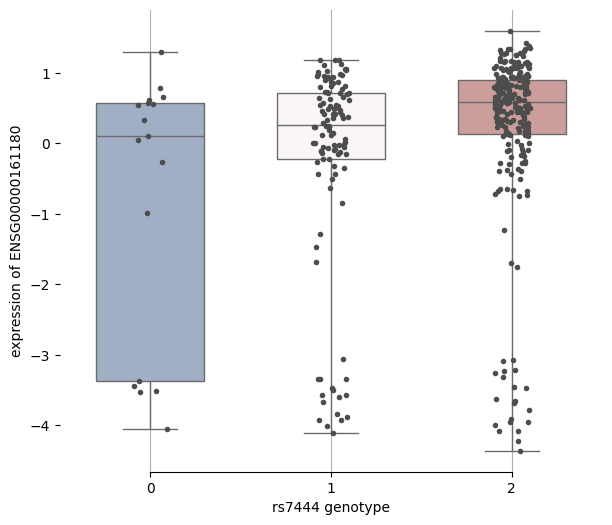

In [35]:
# finally, let's take a look at how these eQTLs seem in a plot

# extract the gene
expression_gene = expression.loc['ENSG00000161180']
# extract the genotype
genotype_variant = genotypes.loc['rs7444']
# combine into one dataframe
variant_to_gene = pd.merge(genotype_variant, expression_gene, right_index = True, left_index = True)

# set the size of the plot
f, ax = plt.subplots(figsize=(7, 6))

# now create the plot
sbs.boxplot(x="rs7444", y="ENSG00000161180", data=variant_to_gene,
            whis=[0, 100], width=.6, palette="vlag")

# Add in points to show each observation
sbs.stripplot(x="rs7444", y="ENSG00000161180", data=variant_to_gene,
              size=4, color=".3", linewidth=0)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="expression of ENSG00000161180")
ax.set(xlabel="rs7444 genotype")
sbs.despine(trim=True, left=True)
